In [244]:
from sklearn.datasets import load_boston
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures

#from sklearn.model_selection import train_test_split #train test split 
####### We actually don't need to test split since thats k cross fold thing is done to test 
#from sklearn.model_selection import StratifiedKFold, cross_val_score

# DO NOT GRADE THSI HOMEWORK! i AM AUDITING THIS COURSE AND THIS SUBMISSION IS ONLY UPLOADED OUT OF A WEIRD DESIRE FOR COMPLETION.


# Closed Form Solution

### Importing Dataset

In [245]:

## Avoid printing out warnings
with warnings.catch_warnings():
     warnings.filterwarnings("ignore")
     X, y = load_boston(return_X_y=True)


#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1234)
#split into training size of 0.8 of the whole, testing size of 0.2 of the whole 
X_original = X
X = np.append(np.ones([len(X), 1]), X, 1)
y = np.reshape(y, (len(y), 1))

#means that we have 506 entries, 13 attributes for each entry 1 attribute of 1 for b 
print(X.shape, y.shape)

attribute = X.shape[1] #find the number of columns in X with all the w and 1 b 
#w_train = np.random.rand(attribute,1)

#w_train has 14 attributes of random values 
#print(w_train.shape) 

#look at 237 page for gradient descent + do that for the dimensions 

(506, 14) (506, 1)


In [246]:
#Normal Equation Solution 
def normal_equation_solution(X, y, lamb = 0): #accepts 2 parameters, the X and the y. 
    #lambda is there to support compatibility with some functions not for use 
    T = X.transpose()
    #one = (T@X)**(-1) #this is not the right way to find the inverse!
    #two = np.linalg.inv(T@X)
    #print(one[0])
    #print(two[0])
    
    w_train_new = np.linalg.inv(T@X)@T@y 
    return np.reshape(w_train_new, (len(w_train_new), 1))
    
def normal_equation_error(X, y, w):
    return y - X @ w 

def normal_equation_predict(X, w):
    return X @ w
    
def normal_equation_loss(X, y, w, lamb = 0):
    y_T = y.transpose() 
    w_T = w.transpose()
    X_T = X.transpose() 
    ridge = lamb * sum((w) ** 2) #this is last part is the ridge equation 
    return y_T @ y - y_T @ X @ w - w_T @ X_T @ y + w_T @ X_T @ X @ w + ridge 
    

'''
#Some sanity checks for validating the test code 
neww = normal_equation_solution(X, y)

print(w_train.shape, neww.shape)

loss_old = normal_equation_loss(X, y, w_train)
loss_new = normal_equation_loss(X, y, neww)
print(w_train, "and this is the old loss", loss_old)
print(neww, "and this is the new loss", loss_new)

y_hat = normal_equation_predict(X,w_train)
print(y_hat.shape)
'''

'\n#Some sanity checks for validating the test code \nneww = normal_equation_solution(X, y)\n\nprint(w_train.shape, neww.shape)\n\nloss_old = normal_equation_loss(X, y, w_train)\nloss_new = normal_equation_loss(X, y, neww)\nprint(w_train, "and this is the old loss", loss_old)\nprint(neww, "and this is the new loss", loss_new)\n\ny_hat = normal_equation_predict(X,w_train)\nprint(y_hat.shape)\n'

### K-Fold Test and Validaton

In [247]:
def k_fold(k, solution_method, lamb = 0, verbose = False):
    #shuffle the datasets 
    permutation = np.random.permutation(len(X))
    X_shuffle = X[permutation]
    y_shuffle = y[permutation] 
    ranges = [0] + [i * (len(X) // k) for i in range(1, k)] + [len(X)]
    #[0, 101, 202, 303, 404, 506]
    #ranges will be 1: [0, 101), 2: [101, 202)... 5: [404, 506).
    #includes all values 

    test_loss = []
    train_loss = []

    for i in range(1, k + 1): 
        #split our range 
        X_test= X[ranges[i-1]:ranges[i], :]
        X_train = np.append(X[:ranges[i-1], :], X[ranges[i]:,:], 0)

        y_test= y[ranges[i-1]:ranges[i], :]
        y_train = np.append(y[:ranges[i-1], :], y[ranges[i]:,:], 0)


        '''
        print(len(training) + len(test)) shows the in total their sum is always 506 
        therefore no data point is left unaccounted for in the case where points are 
        not divided evenly
        '''

        #train the model using the training and evaluate with test 
        w_train = solution_method(X_train, y_train, lamb)
        
        #while training, use the lambda, while testing, do not 
        loss = normal_equation_loss(X_test, y_test, w_train, 0) 
        test_loss.append(loss)
        loss = normal_equation_loss(X_train, y_train, w_train, 0)
        train_loss.append(loss)
        
        
    if verbose: #print the scores of the model 
        print("Test average loss:", sum(test_loss)/k)
        print("Train average loss:", sum(train_loss)/k)
        #Print the average of your recorded scores for both the test set and training set.

    #error_rate = sum(total_loss) / k 
    #print("Average error_rate:", error_rate)
    return sum(test_loss) / k

### Print Results

In [248]:
k_fold(5, normal_equation_solution, lamb = 0, verbose = True)

Test average loss: [[3747.06437356]]
Train average loss: [[8391.1302353]]


array([[3747.06437356]])

# Ridge Regression

### Validating RR on Different Lambda Values and Reporting the Best Lambda

Using lambda as 10.0
Test average loss: [[3285.23535133]]
Train average loss: [[9383.48398322]]


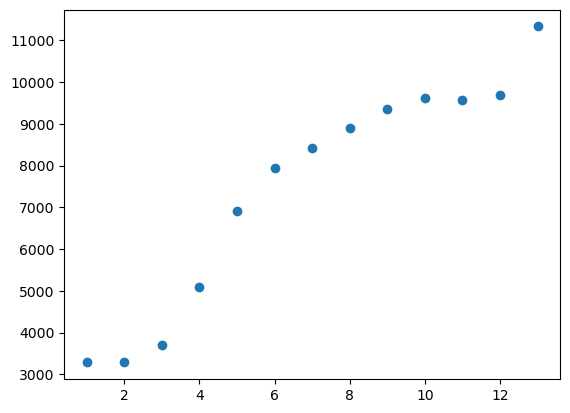

In [249]:
lambda_val = np.logspace(1, 7, num=13)
#print(lambda_val)
loss_result = []

def normal_ridge_solution(X, y, lamb): #given the ridge 
    T = X.transpose()
    inv = np.linalg.inv(X@T+lamb*np.identity(len(X)))
    w = T@(inv)@y
    return w 

def validate_lambda():
    for lamb in lambda_val:
        loss = k_fold(5, normal_ridge_solution, lamb)
        loss_result.append(loss)

    plt.scatter([i for i in range(1, len(loss_result) + 1)], loss_result)

    ind = loss_result.index(min(loss_result)) #find the index of the minimum loss
    print("Using lambda as", lambda_val[ind])
    k_fold(5, normal_ridge_solution, lambda_val[ind], verbose=True)
validate_lambda()

### Polynomial Transformation and Repeating Ridge Regression 

Using lambda as 1000000.0
Test average loss: [[3690.58044375]]
Train average loss: [[5313.58243665]]


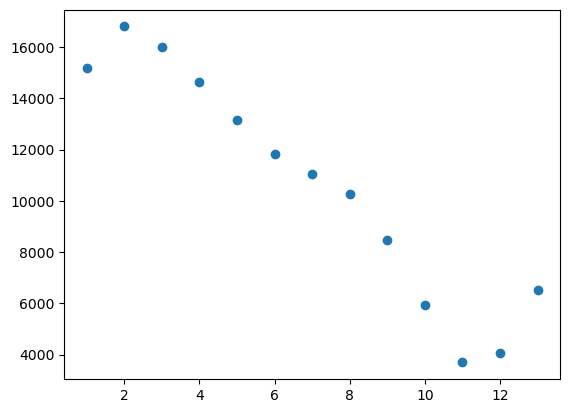

In [250]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

lambda_val = np.logspace(1, 7, num=13)
#print(lambda_val)
loss_result = []

temp = X #remember X but set X to X_poly temporarily such that other functions are not impacted 
X = X_poly
    
validate_lambda()

X = temp

# Gradient Descent

In [255]:
def MSE_grad(X, y, w):
    X_T = X.transpose()
    m = len(X)
    w_T = w.transpose()
    #grad = [2/len(X) * sum([((w_T@X[i]) - y[i]) * X[i,j] for i in range(len(X))]) for j in range(len(X[0]))]
    grad = 
    #print(pred)
    return np.array(grad)
#gradient(X,y,np.random.rand(attribute,1))

### Linear Regression using Gradient Descent

Final weights: [[ 0.86865779]
 [ 0.29970395]
 [ 0.90447818]
 [ 0.69827873]
 [ 0.12886465]
 [ 0.21422664]
 [ 0.9043947 ]
 [ 0.33856446]
 [ 0.31588943]
 [ 0.83110699]
 [ 0.17001483]
 [ 0.67688994]
 [-0.16872579]
 [ 0.53847826]]


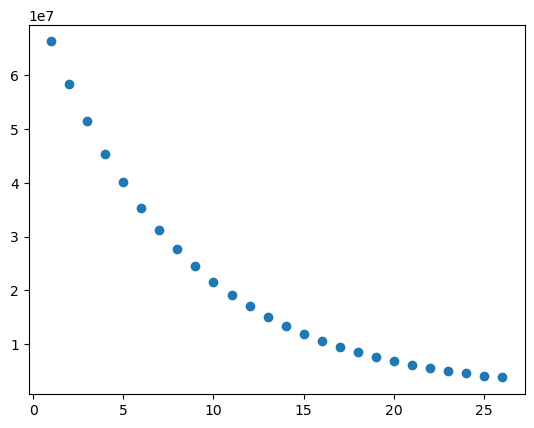

In [252]:
def gradient_descent(epochs, learning_rate, gradient_func, cost_func, param=None, verbose = False):
    w_train = np.random.rand(attribute,1)

    #gradient(X, y, w_train)

    loss_history = [normal_equation_loss(X, y, w_train)]

    for epoch in range(epochs): #training loop 

        derive = gradient_func(X,y,w_train, param) if param else gradient_func(X,y,w_train)

        #update the matrix for the answer with the right loss function
        w_new = w_train - learning_rate * derive
        w_train = w_new 

        loss = cost_func(X, y, w_train, param) if param else cost_func(X, y, w_train)
        loss_history.append(loss)

    plt.scatter([i for i in range(1, len(loss_history) + 1)],loss_history)
    #print(loss_history)
    if verbose:
        print("Final weights:", w_train)
        
gradient_descent(25, 0.0000001, MSE_grad, normal_equation_loss, verbose = True)

### Lasso Regression using Gradient Descent

Final weights: [[ 1.09381705e-01]
 [ 4.84179382e-01]
 [ 5.66628080e-04]
 [-9.14374799e-03]
 [ 7.23128601e-01]
 [ 4.72323588e-02]
 [-4.19380905e-03]
 [ 3.56295199e-01]
 [ 5.46242856e-01]
 [ 3.69443645e-01]
 [-9.29914167e-03]
 [ 5.81778049e-02]
 [ 1.03243277e-01]
 [ 6.80883510e-01]]


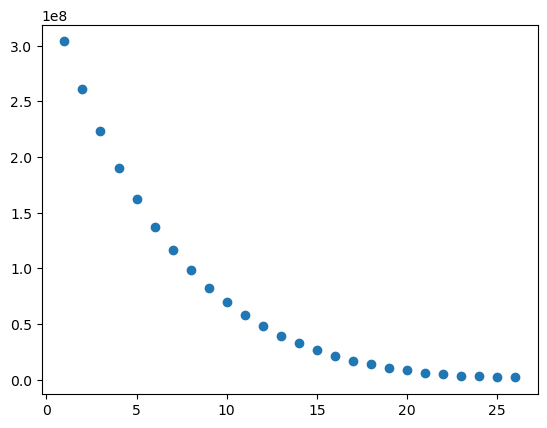

In [253]:
def lasso_cost(X,y,w,param=(0,)):
    a = param[0]
    return normal_equation_loss(X, y, w) + a * sum(abs(val) for val in w)
    
def lasso_grad(X,y,w,param=(0,)):
    a = param[0]
    grad = np.zeros([len(w),1])
    for j in range(len(w)):
        if w[j] < 0:
            grad[j] = -1
        elif w[j] > 0:
            grad[j] = 1 
    return MSE_grad(X,y,w) + a * grad
    
#lasso_grad(X,y,np.random.rand(attribute,1))
gradient_descent(25, 0.0000001, lasso_grad, lasso_cost, param=(100000,), verbose = True)

### Elastic Net using Gradient Descent

Final weights: [[ 0.47520003]
 [ 0.37439345]
 [ 0.51470562]
 [ 0.41226832]
 [ 0.39281599]
 [ 0.04418648]
 [ 0.36945896]
 [ 0.20247664]
 [ 0.76533082]
 [-0.00205952]
 [ 0.05834985]
 [ 0.00296931]
 [ 0.0024149 ]
 [ 0.73632067]]


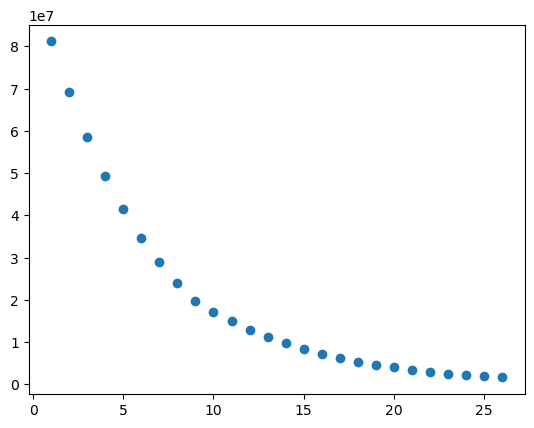

In [254]:
def elastic_cost(X,y,w,param=(0,0)):
    a,r=param
    normal = normal_equation_loss(X,y,w)
    lasso = r*a*sum(abs(val) for val in w)
    ridge = a*(1-r)/2 * sum(val**2 for val in w)
    return normal + lasso + ridge 

def elastic_gradient(X,y,w,param=(0,0)):
    a,r=param
    lasso = np.zeros([len(w),1])
    for j in range(len(w)):
        if w[j] < 0:
            lasso[j] = -1
        elif w[j] > 0:
            lasso[j] = 1 
            
    ridge = 2 * w
            
    return MSE_grad(X,y,w) + r*a * lasso + (1-r) / 2 * ridge #multiplied by 2w 
    
gradient_descent(25, 0.0000001, elastic_gradient, elastic_cost, param=(100000,0.8), verbose = True)

### Answer to the Theoretical Question #10 

I would choose to use elastic net. The reason for that is I can combine the best features of lasso regression with ridge regression to create a function that can better minimize usless values. In particular, I would use it in conjunction with polynomial transformation so that I can determine which values are actually important for the housing market. 

#### The parameters I would use would be:
- r = 0.8 to put more emphasis on lasso regression 
- a = 10000 to put a lot of penalty to prevent overfitting 
- learning rate = 0.0000001 larger rate causes the function to jump from positive to negative 
- epochs = 100 to start but we can increase if the function is still improving